## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load datasets
owned_games = pd.read_csv('../data/owned_games_enriched.csv')
steam_catalog = pd.read_csv('../data/steam_catalog_detailed.csv')

print(f"Owned games: {len(owned_games)} games")
print(f"Steam catalog: {len(steam_catalog)} games")
print(f"\nOwned games columns: {list(owned_games.columns)}")

Owned games: 67 games
Steam catalog: 86542 games

Owned games columns: ['appid', 'name', 'playtime_forever', 'img_icon_url', 'playtime_windows_forever', 'playtime_mac_forever', 'playtime_linux_forever', 'playtime_deck_forever', 'rtime_last_played', 'content_descriptorids', 'playtime_disconnected', 'has_community_visible_stats', 'playtime_2weeks', 'has_leaderboards', 'playtime_hours', 'developer', 'publisher', 'score_rank', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'positive', 'negative', 'userscore', 'ccu', 'price', 'initialprice', 'discount', 'tags', 'languages', 'genre']


## 1. Create Engagement Score (Target Variable)

The engagement score combines:
- Playtime (normalized)
- Recency of play
- Whether game has achievements/stats

Engagement Score Statistics:
count    67.000000
mean     61.034002
std      24.927157
min       0.000000
25%      55.127533
50%      66.747135
75%      77.806766
max      99.983783
Name: engagement_score, dtype: float64


C:\Users\rivie\AppData\Local\Temp\ipykernel_35096\3358854333.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['achievement_score'] = df['has_community_visible_stats'].fillna(False).astype(int) * 10


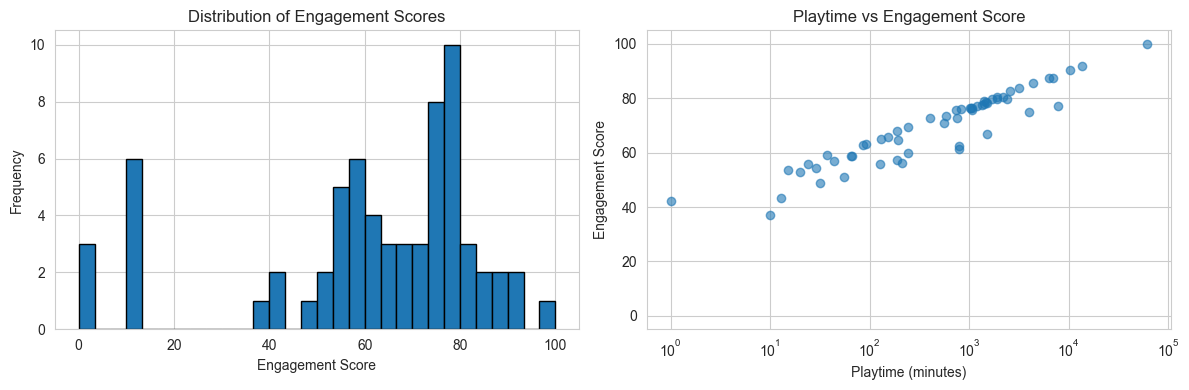

In [3]:
def create_engagement_score(df):
    """
    Create engagement score from playtime and other features
    Score ranges from 0-100
    """
    df = df.copy()
    
    # Playtime component (0-60 points)
    # Use log transform to handle skewed distribution
    df['playtime_score'] = np.log1p(df['playtime_forever'])
    df['playtime_score'] = (df['playtime_score'] / df['playtime_score'].max()) * 60
    
    # Recency component (0-30 points)
    # More recent play = higher score
    if 'rtime_last_played' in df.columns and df['rtime_last_played'].notna().any():
        max_time = df['rtime_last_played'].max()
        df['recency_score'] = df['rtime_last_played'].fillna(0)
        df['recency_score'] = (df['recency_score'] / max_time) * 30
    else:
        df['recency_score'] = 0
    
    # Achievement engagement (0-10 points)
    df['achievement_score'] = df['has_community_visible_stats'].fillna(False).astype(int) * 10
    
    # Combine scores
    df['engagement_score'] = (
        df['playtime_score'] + 
        df['recency_score'] + 
        df['achievement_score']
    )
    
    return df

owned_games = create_engagement_score(owned_games)

# Display engagement score distribution
print("Engagement Score Statistics:")
print(owned_games['engagement_score'].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(owned_games['engagement_score'], bins=30, edgecolor='black')
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Scores')

plt.subplot(1, 2, 2)
plt.scatter(owned_games['playtime_forever'], owned_games['engagement_score'], alpha=0.6)
plt.xlabel('Playtime (minutes)')
plt.ylabel('Engagement Score')
plt.title('Playtime vs Engagement Score')
plt.xscale('log')
plt.tight_layout()
plt.show()

## 2. Extract Tag Features from Owned Games

Parse the tag dictionaries and create a feature matrix where:
- Rows = games
- Columns = tags
- Values = tag vote counts

In [4]:
def parse_tags(tag_string):
    """
    Parse tag string into dictionary
    Handles both string and NaN values
    """
    if pd.isna(tag_string):
        return {}
    try:
        return ast.literal_eval(str(tag_string))
    except:
        return {}

# Parse tags for owned games
owned_games['tags_dict'] = owned_games['tags'].apply(parse_tags)

# Get all unique tags from owned games
all_tags = set()
for tags_dict in owned_games['tags_dict']:
    all_tags.update(tags_dict.keys())

print(f"Total unique tags in owned games: {len(all_tags)}")
print(f"\nSample tags: {list(all_tags)[:10]}")

Total unique tags in owned games: 193

Sample tags: ['Online Co-Op', 'Strategy', 'Capitalism', 'Arcade', 'Psychological Horror', 'Action RPG', 'City Builder', 'Looter Shooter', 'Diplomacy', 'Survival']


In [5]:
# Create tag feature matrix
def create_tag_features(df, all_tags):
    """
    Create a feature matrix where each column is a tag
    and values are the vote counts (or 0 if tag not present)
    """
    tag_features = pd.DataFrame(index=df.index)
    
    for tag in sorted(all_tags):
        # Clean tag name for column (remove special chars)
        col_name = f"tag_{tag.replace(' ', '_').replace('-', '_').replace('&', 'and')}"
        tag_features[col_name] = df['tags_dict'].apply(
            lambda x: x.get(tag, 0) if isinstance(x, dict) else 0
        )
    
    return tag_features

tag_features = create_tag_features(owned_games, all_tags)
print(f"Tag feature matrix shape: {tag_features.shape}")
print(f"\nFirst few tag columns:\n{tag_features.iloc[:5, :5]}")

Tag feature matrix shape: (67, 193)

First few tag columns:
   tag_1980s  tag_1990's  tag_2D  tag_2D_Platformer  tag_3D
0          0        1984       0                  0       0
1          0           0       0                  0       0
2          0           0       0                  0       0
3          0           0       0                  0       0
4          0           0       0                  0       0


C:\Users\rivie\AppData\Local\Temp\ipykernel_35096\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_35096\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_features[col_name] = df['tags_dict'].apply(
C:\Users\rivie\AppData\Local\Temp\ipykernel_35096\1221151379.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

## 3. Create Interaction Features

Weight tag votes by playtime to capture which tags the user actually engages with

In [6]:
# Create playtime weight (normalized)
owned_games['playtime_weight'] = np.log1p(owned_games['playtime_forever'])
owned_games['playtime_weight'] = owned_games['playtime_weight'] / owned_games['playtime_weight'].max()

# Create interaction features (tag_votes * playtime_weight)
interaction_features = tag_features.multiply(owned_games['playtime_weight'], axis=0)
interaction_features.columns = [col.replace('tag_', 'interaction_') for col in interaction_features.columns]

print(f"Interaction feature matrix shape: {interaction_features.shape}")
print(f"\nPlaytime weight statistics:")
print(owned_games['playtime_weight'].describe())

Interaction feature matrix shape: (67, 193)

Playtime weight statistics:
count    67.000000
mean      0.480196
std       0.258305
min       0.000000
25%       0.323306
50%       0.544842
75%       0.662451
max       1.000000
Name: playtime_weight, dtype: float64


## 4. Additional Game Features

Extract only essential features needed for ML

In [7]:
# Create minimal additional features - just what's needed for core ML
additional_features = pd.DataFrame(index=owned_games.index)

# Average playtime from catalog (how long do other players engage with this game?)
# This helps ML understand if a game is "short" or "long" in general
additional_features['catalog_avg_playtime'] = np.log1p(owned_games['average_forever'].fillna(0))

# Median playtime (another engagement signal)
additional_features['catalog_median_playtime'] = np.log1p(owned_games['median_forever'].fillna(0))

print(f"Additional features shape: {additional_features.shape}")
print(f"\nAdditional features:\n{additional_features.head()}")
print(f"\nThese features help ML understand community engagement patterns")

Additional features shape: (67, 2)

Additional features:
   catalog_avg_playtime  catalog_median_playtime
0              7.855932                 4.962845
1              7.646354                 5.894403
2              6.492240                 3.583519
3              4.727388                 2.564949
4              6.432940                 5.081404

These features help ML understand community engagement patterns


## 5. Combine All Features and Prepare X, y

In [8]:
# Combine all feature sets
X = pd.concat([
    tag_features,
    interaction_features,
    additional_features
], axis=1)

# Target variable
y = owned_games['engagement_score']

# Keep game metadata for reference
game_metadata = owned_games[['appid', 'name', 'playtime_forever', 'engagement_score']].copy()

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target variable (y) shape: {y.shape}")
print(f"\nFeature types:")
print(f"  - Tag features: {len(tag_features.columns)}")
print(f"  - Interaction features: {len(interaction_features.columns)}")
print(f"  - Additional features: {len(additional_features.columns)}")
print(f"  - Total: {X.shape[1]}")

Feature matrix (X) shape: (67, 388)
Target variable (y) shape: (67,)

Feature types:
  - Tag features: 193
  - Interaction features: 193
  - Additional features: 2
  - Total: 388


In [9]:
# Check for missing values
missing_summary = pd.DataFrame({
    'missing_count': X.isnull().sum(),
    'missing_pct': (X.isnull().sum() / len(X)) * 100
})
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_count', ascending=False)

if len(missing_summary) > 0:
    print(f"Warning: {len(missing_summary)} features have missing values")
    print(missing_summary.head(10))
else:
    print("✓ No missing values in feature matrix")

✓ No missing values in feature matrix


## 6. Train/Test Split (80/20)

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Also split metadata for reference
metadata_train, metadata_test = train_test_split(
    game_metadata,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train/Test Split Results:")
print(f"  Training set: {X_train.shape[0]} games ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} games ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTarget distribution:")
print(f"  Train mean: {y_train.mean():.2f} (std: {y_train.std():.2f})")
print(f"  Test mean: {y_test.mean():.2f} (std: {y_test.std():.2f})")

Train/Test Split Results:
  Training set: 53 games (79.1%)
  Test set: 14 games (20.9%)

Target distribution:
  Train mean: 61.02 (std: 26.02)
  Test mean: 61.09 (std: 21.13)


## 7. Feature Scaling

Standardize features for models that are sensitive to scale

In [11]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete!")
print(f"\nScaled features range:")
print(f"  Train min: {X_train_scaled.min().min():.2f}")
print(f"  Train max: {X_train_scaled.max().max():.2f}")
print(f"  Train mean: {X_train_scaled.mean().mean():.2e}")
print(f"  Train std: {X_train_scaled.std().mean():.2f}")

Feature Scaling Complete!

Scaled features range:
  Train min: -2.61
  Train max: 7.21
  Train mean: -5.07e-18
  Train std: 0.86


## 8. Feature Analysis

Analyze which features might be most predictive

In [12]:
# Calculate correlation with target
feature_correlations = pd.DataFrame({
    'feature': X_train.columns,
    'correlation': [X_train[col].corr(y_train) for col in X_train.columns]
})
feature_correlations['abs_correlation'] = feature_correlations['correlation'].abs()
feature_correlations = feature_correlations.sort_values('abs_correlation', ascending=False)

print("Top 20 Features by Correlation with Engagement Score:")
print(feature_correlations.head(20).to_string(index=False))

Top 20 Features by Correlation with Engagement Score:
                         feature  correlation  abs_correlation
              interaction_Action     0.435785         0.435785
        interaction_Singleplayer     0.420979         0.420979
         catalog_median_playtime     0.407551         0.407551
         interaction_Atmospheric     0.393608         0.393608
           interaction_Adventure     0.384992         0.384992
          interaction_Story_Rich     0.382805         0.382805
        interaction_First_Person     0.348993         0.348993
          interaction_Open_World     0.339773         0.339773
                 interaction_FPS     0.339602         0.339602
    interaction_Great_Soundtrack     0.338952         0.338952
                  tag_Old_School    -0.328307         0.328307
                tag_Singleplayer     0.324206         0.324206
              interaction_Sci_fi     0.323308         0.323308
         interaction_Exploration     0.322913         0.322913
 

c:\Users\rivie\vsCodeProjects\GameRecMLProject\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rivie\vsCodeProjects\GameRecMLProject\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


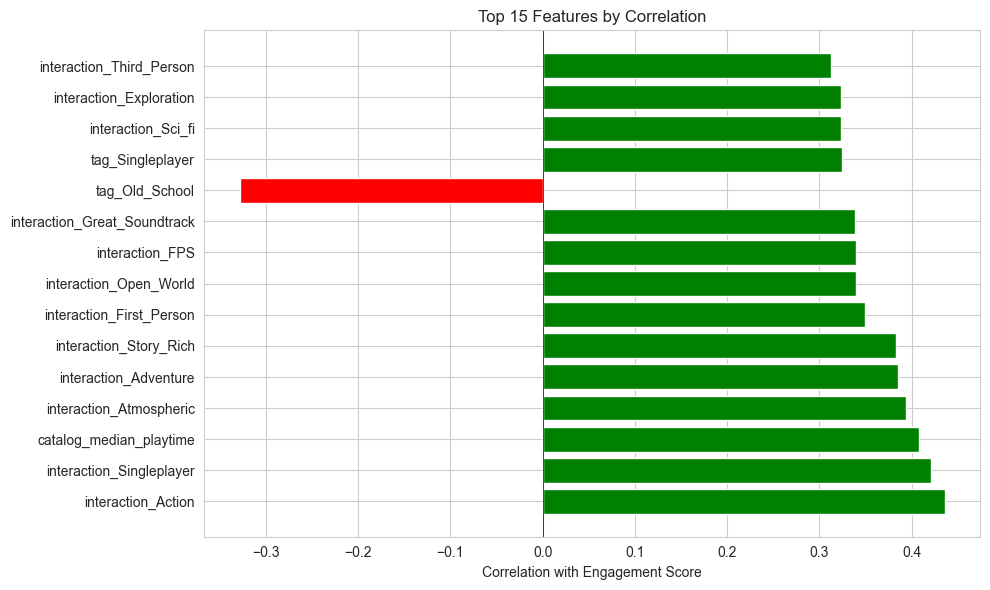

In [13]:
# Visualize top correlations
top_features = feature_correlations.head(15)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in top_features['correlation']]
plt.barh(range(len(top_features)), top_features['correlation'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Correlation with Engagement Score')
plt.title('Top 15 Features by Correlation')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 9. Save Processed Data

Save the prepared datasets for model training

In [14]:
# Save to CSV files
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False, header=['engagement_score'])
y_test.to_csv('../data/y_test.csv', index=False, header=['engagement_score'])

# Save scaled versions
X_train_scaled.to_csv('../data/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/X_test_scaled.csv', index=False)

# Save metadata
metadata_train.to_csv('../data/metadata_train.csv', index=False)
metadata_test.to_csv('../data/metadata_test.csv', index=False)

# Save feature info
feature_correlations.to_csv('../data/feature_correlations.csv', index=False)

print("✓ All processed data saved to ../data/")
print("\nFiles created:")
print("  - X_train.csv, X_test.csv")
print("  - X_train_scaled.csv, X_test_scaled.csv")
print("  - y_train.csv, y_test.csv")
print("  - metadata_train.csv, metadata_test.csv")
print("  - feature_correlations.csv")

✓ All processed data saved to ../data/

Files created:
  - X_train.csv, X_test.csv
  - X_train_scaled.csv, X_test_scaled.csv
  - y_train.csv, y_test.csv
  - metadata_train.csv, metadata_test.csv
  - feature_correlations.csv


## Summary

### Feature Engineering Complete! ✓

**Created Features:**
- **Tag vote features**: Raw tag popularity from games you own
- **Interaction features**: Tags weighted by YOUR playtime (core ML signal)
- **Catalog playtime features**: Average/median playtime from Steam community (engagement signal)

**Target Variable:**
- **Engagement score** (0-100): Combines playtime, recency, and achievements

**The ML Approach:**
1. Learn which tag patterns correlate with YOUR high engagement (playtime)
2. Apply learned patterns to catalog games you don't own
3. Recommend games with similar tag profiles to your loved games

**Dataset Split:**
- 80% training, 20% test
- Both raw and scaled versions saved


**Next Steps:**
1. Train Random Forest on tag features → engagement score
2. Apply trained model to Steam catalog (non-owned games)
3. Recommend top predicted games
4. Evaluate: Does ML predict your engagement accurately?